https://www.kaggle.com/code/thuytran0605/cutmixolddata?scriptVersionId=241180973

In [1]:
!pip install torch==1.13.1 torchvision==0.14.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu121
    Uninstalling torchvision-0.20.1+cu121:
      Successfully uninstalled torchvision-0.20.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency

In [2]:
# 1. Import thư viện và thiết lập môi trường
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models
import timm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Seed để tái tạo kết quả
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Sử dụng device: {device}')

# 2. Đường dẫn dữ liệu - Sử dụng dữ liệu đã phân chia sẵn
# Đường dẫn chính (điều chỉnh theo môi trường của bạn)
SPLIT_DIR = '/kaggle/input/isic19reduced66/ISIC_2019_Reduced'

# Đường dẫn train
TRAIN_IMG_DIR = os.path.join(SPLIT_DIR, 'train/images')
TRAIN_SEG_DIR = os.path.join(SPLIT_DIR, 'train/segmentations')
TRAIN_LABELS_PATH = os.path.join(SPLIT_DIR, 'train_labels.csv')
TRAIN_METADATA_PATH = os.path.join(SPLIT_DIR, 'train_metadata.csv')

# Đường dẫn validation
TEST_IMG_DIR = os.path.join(SPLIT_DIR, 'valid/images')
TEST_SEG_DIR = os.path.join(SPLIT_DIR, 'valid/segmentations')
TEST_LABELS_PATH = os.path.join(SPLIT_DIR, 'valid_labels.csv')
TEST_METADATA_PATH = os.path.join(SPLIT_DIR, 'valid_metadata.csv')

# Đường dẫn test
VAL_IMG_DIR = os.path.join(SPLIT_DIR, 'test/images')
VAL_SEG_DIR = os.path.join(SPLIT_DIR, 'test/segmentations')
VAL_LABELS_PATH = os.path.join(SPLIT_DIR, 'test_labels.csv')
VAL_METADATA_PATH = os.path.join(SPLIT_DIR, 'test_metadata.csv')

# Khởi tạo thư mục để lưu checkpoint và kết quả
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('results', exist_ok=True)

# 3. Hàm chuyển đổi từ one-hot labels sang single label (đa lớp)
def convert_to_multiclass(df):
    """Chuyển đổi từ dạng one-hot (nhiều cột nhãn) sang nhãn dạng số"""
    # Tìm các cột nhãn (loại bỏ 'image', 'diagnosis', 'label' nếu có)
    label_columns = [col for col in df.columns if col not in ['image', 'diagnosis', 'label']]
    
    # Tạo bản sao để tránh thay đổi df gốc
    result_df = df.copy()
    
    # Tạo cột 'diagnosis' chứa tên của lớp có giá trị 1.0
    result_df['diagnosis'] = result_df[label_columns].idxmax(axis=1)
    
    # Tạo ánh xạ từ tên lớp sang số
    class_names = sorted(label_columns)
    label_map = {class_name: i for i, class_name in enumerate(class_names)}
    
    # Tạo cột 'label' chứa chỉ số số nguyên của lớp
    result_df['label'] = result_df['diagnosis'].map(label_map)
    
    return result_df, label_map, class_names

# Add this function after the convert_to_multiclass function
def filter_to_three_classes(df):
    """Filter dataframe to keep only NV, MEL, and BKL classes"""
    # Find columns that aren't image identifiers
    label_columns = [col for col in df.columns if col not in ['image', 'diagnosis', 'label']]
    
    # Create a new dataframe with only the needed classes
    target_classes = ['NV', 'MEL', 'BKL']
    filtered_cols = ['image'] + [col for col in label_columns if col in target_classes]
    
    # Filter rows that have at least one of these classes
    filtered_df = df[filtered_cols].copy()
    row_filter = filtered_df[target_classes].sum(axis=1) > 0
    filtered_df = filtered_df[row_filter].copy()
    
    # Normalize the remaining rows to ensure the sum is 1.0
    for i, row in filtered_df.iterrows():
        class_sum = row[target_classes].sum()
        if class_sum > 0:
            filtered_df.loc[i, target_classes] = row[target_classes] / class_sum
    
    return filtered_df

# 4. Xử lý dữ liệu metadata
def process_metadata(metadata_df):
    """Xử lý metadata để đảm bảo không có giá trị thiếu và các kiểu dữ liệu phù hợp"""
    # Lọc cột cần dùng
    metadata_df = metadata_df[['image', 'age_approx', 'anatom_site_general', 'sex']].copy()
    
    # Xử lý cột age_approx
    metadata_df['age_approx'] = pd.to_numeric(metadata_df['age_approx'], errors='coerce')
    age_mean = metadata_df['age_approx'].mean()
    metadata_df['age_approx'] = metadata_df['age_approx'].fillna(age_mean)
    
    # Chuẩn hóa age_approx về khoảng [0, 1]
    age_min = metadata_df['age_approx'].min()
    age_max = metadata_df['age_approx'].max()
    metadata_df['age_approx'] = (metadata_df['age_approx'] - age_min) / (age_max - age_min)
    
    # Xử lý cột anatom_site_general
    metadata_df['anatom_site_general'] = metadata_df['anatom_site_general'].fillna('unknown')
    site_dummies = pd.get_dummies(metadata_df['anatom_site_general'], prefix='site')
    
    # Xử lý cột sex
    metadata_df['sex'] = metadata_df['sex'].fillna('unknown')
    sex_dummies = pd.get_dummies(metadata_df['sex'], prefix='sex')
    
    # Kết hợp các cột
    metadata_processed = pd.concat([
        metadata_df[['image']],
        metadata_df[['age_approx']],
        site_dummies,
        sex_dummies
    ], axis=1)
    
    # Đảm bảo không có giá trị NaN
    metadata_processed = metadata_processed.fillna(0)
    
    # Xác định các cột đặc trưng
    meta_feature_cols = metadata_processed.columns.tolist()[1:]
    
    return metadata_processed, meta_feature_cols

# 5. Định nghĩa transformations cho augmentation
def get_train_transforms(use_seg=True):
    height, width = 224, 224
    n_channels = 3 + (1 if use_seg else 0)
    
    return A.Compose([
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15),
        A.RandomBrightnessContrast(),
        A.Resize(height=height, width=width),
        A.Normalize(mean=[0.485, 0.456, 0.406] + [0.5] * (n_channels - 3),
                   std=[0.229, 0.224, 0.225] + [0.5] * (n_channels - 3)),
        ToTensorV2(),
    ])

def get_valid_transforms(use_seg=True):
    height, width = 224, 224
    n_channels = 3 + (1 if use_seg else 0)
    
    return A.Compose([
        A.Resize(height=height, width=width),
        A.Normalize(mean=[0.485, 0.456, 0.406] + [0.5] * (n_channels - 3),
                   std=[0.229, 0.224, 0.225] + [0.5] * (n_channels - 3)),
        ToTensorV2(),
    ])

# 6. Dataset class cho phân loại đa lớp
class DermDataset(Dataset):
    def __init__(self, img_dir, df, metadata_df=None, meta_cols=None, seg_dir=None, 
                 transform=None, use_seg=True, use_meta=False):
        self.img_dir = img_dir
        self.df = df
        self.metadata_df = metadata_df
        self.meta_cols = meta_cols
        self.seg_dir = seg_dir
        self.transform = transform
        self.use_seg = use_seg
        self.use_meta = use_meta
        
        self.image_names = df['image'].values
        # Thay đổi: sử dụng nhãn dạng số thay vì one-hot
        self.labels = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        
        # Đọc ảnh
        img_path = os.path.join(self.img_dir, img_name + '.jpg')
        img = cv2.imread(img_path)
        if img is None:
            img_path = os.path.join(self.img_dir, img_name + '.jpeg')
            img = cv2.imread(img_path)
        if img is None:
            img_path = os.path.join(self.img_dir, img_name + '.png')
            img = cv2.imread(img_path)
            
        if img is None:
            print(f"Không tìm thấy ảnh: {img_name}")
            img = np.zeros((224, 224, 3), dtype=np.uint8)
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Đọc segmentation mask nếu cần
        if self.use_seg and self.seg_dir is not None:
            seg_path = os.path.join(self.seg_dir, img_name + '_seg.png')
            if os.path.exists(seg_path):
                seg_mask = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
                if seg_mask.shape[:2] != img.shape[:2]:
                    seg_mask = cv2.resize(seg_mask, (img.shape[1], img.shape[0]), 
                                         interpolation=cv2.INTER_NEAREST)
                
                if seg_mask.max() > 1:
                    seg_mask = seg_mask / 255.0
                
                img = np.dstack((img, seg_mask))
        
        # Áp dụng transform
        if self.transform:
            augmented = self.transform(image=img)
            image = augmented['image']
        else:
            image = img
        
        # Lấy metadata nếu cần
        meta_features = None
        if self.use_meta and self.metadata_df is not None and self.meta_cols is not None:
            meta_row = self.metadata_df[self.metadata_df['image'] == img_name]
            if not meta_row.empty:
                try:
                    meta_values = meta_row[self.meta_cols].values[0].astype(np.float32)
                    meta_features = torch.tensor(meta_values, dtype=torch.float32)
                except Exception as e:
                    print(f"Lỗi chuyển đổi metadata cho ảnh {img_name}: {e}")
                    meta_features = torch.zeros(len(self.meta_cols), dtype=torch.float32)
            else:
                meta_features = torch.zeros(len(self.meta_cols), dtype=torch.float32)
        
        # Thay đổi: Chuyển nhãn từ integer sang long tensor
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        if meta_features is not None:
            return image, meta_features, label
        else:
            return image, label

# 7. DataLoader function
def create_dataloaders(train_df, val_df, test_df=None, metadata_df=None, meta_cols=None,
                      use_seg=True, use_meta=False, batch_size=16, num_workers=4):
    train_dataset = DermDataset(
        img_dir=TRAIN_IMG_DIR,
        df=train_df,
        metadata_df=metadata_df,
        meta_cols=meta_cols,
        seg_dir=TRAIN_SEG_DIR if use_seg else None,
        transform=get_train_transforms(use_seg),
        use_seg=use_seg,
        use_meta=use_meta
    )
    
    val_dataset = DermDataset(
        img_dir=VAL_IMG_DIR,
        df=val_df,
        metadata_df=metadata_df,
        meta_cols=meta_cols,
        seg_dir=VAL_SEG_DIR if use_seg else None,
        transform=get_valid_transforms(use_seg),
        use_seg=use_seg,
        use_meta=use_meta
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size*2,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = None
    if test_df is not None:
        test_dataset = DermDataset(
            img_dir=TEST_IMG_DIR,
            df=test_df,
            metadata_df=metadata_df,
            meta_cols=meta_cols,
            seg_dir=TEST_SEG_DIR if use_seg else None,
            transform=get_valid_transforms(use_seg),
            use_seg=use_seg,
            use_meta=use_meta
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size*2,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )
    
    return train_loader, val_loader, test_loader

# 8. Mô hình Vision Transformer cho phân loại đa lớp với metadata
class DermModelWithMeta(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=3, use_seg=True, 
                use_meta=True, meta_dim=0, pretrained=True):
        super(DermModelWithMeta, self).__init__()
        self.use_seg = use_seg
        self.use_meta = use_meta
        
        # Số kênh đầu vào
        in_channels = 3  # RGB
        if use_seg:
            in_channels += 1  # +1 cho segmentation mask
        
        # Khởi tạo mô hình backbone ViT
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            in_chans=in_channels
        )
        
        # Lấy số feature của lớp cuối cùng trong backbone
        if 'vit' in model_name:
            backbone_out = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
        elif 'deit' in model_name:
            backbone_out = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
        elif 'swin' in model_name:
            backbone_out = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
        elif 'efficientnet' in model_name:
            backbone_out = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
        elif 'resnet' in model_name:
            backbone_out = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            raise NotImplementedError(f"Model {model_name} chưa được hỗ trợ")
        
        # Mạng xử lý metadata
        self.meta_dim = meta_dim
        if use_meta and meta_dim > 0:
            self.meta_processor = nn.Sequential(
                nn.Linear(meta_dim, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(0.2)
            )
            
            # Lớp phân loại đa lớp (output là logits cho mỗi lớp)
            self.classifier = nn.Sequential(
                nn.Linear(backbone_out + 64, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )
        else:
            self.meta_processor = None
            self.classifier = nn.Linear(backbone_out, num_classes)
            
    def forward(self, x, meta=None):
        # Trích xuất features từ ảnh
        img_features = self.backbone(x)
        
        # Xử lý metadata nếu có
        if self.use_meta and meta is not None and self.meta_processor is not None:
            meta_features = self.meta_processor(meta)
            # Kết hợp features
            combined_features = torch.cat([img_features, meta_features], dim=1)
            # Đưa qua classifier
            output = self.classifier(combined_features)
        else:
            output = self.classifier(img_features)
            
        return output

# 9. Focal Loss cho bài toán đa lớp
class MultiClassFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        alpha: Tensor có kích thước [C] là trọng số cho mỗi lớp
        gamma: Tham số focusing (giảm trọng số cho các mẫu dễ phân loại)
        """
        super(MultiClassFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, 
                                 weight=self.alpha,
                                 reduction='none')
        
        # Tính xác suất của lớp đúng
        p = F.softmax(inputs, dim=1)
        p_t = p[range(targets.shape[0]), targets]
        
        # Áp dụng trọng số focal
        focal_weight = (1 - p_t) ** self.gamma
        
        # Tính loss
        loss = focal_weight * ce_loss
            
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# 10. Hàm MixUp và CutMix cho phân loại đa lớp
def mixup_for_multiclass(data, targets, alpha=1.0):
    """MixUp cho phân loại đa lớp"""
    indices = torch.randperm(data.size(0)).to(data.device)
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    
    lam = np.random.beta(alpha, alpha)
    mixed_data = lam * data + (1 - lam) * shuffled_data
    
    return mixed_data, targets, shuffled_targets, lam

def rand_bbox(size, lam):
    """Hỗ trợ cho CutMix"""
    W = size[2]
    H = size[3]
    
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    return bbx1, bby1, bbx2, bby2

def cutmix_for_multiclass(data, targets, alpha=1.0):
    """CutMix cho phân loại đa lớp"""
    indices = torch.randperm(data.size(0)).to(data.device)
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    
    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size(-1) * data.size(-2)))
    
    return data, targets, shuffled_targets, lam

# 11. Hàm train với MixUp và CutMix cho đa lớp
def train_epoch_multiclass(model, dataloader, optimizer, criterion, device, 
                          mixaug_prob=0.4, mixup_alpha=0.4, cutmix_alpha=1.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    
    for batch_idx, batch in enumerate(progress_bar):
        if len(batch) == 3:  # Có metadata
            images, metadata, targets = batch
            images = images.to(device)
            metadata = metadata.to(device)
            targets = targets.to(device)
        else:  # Không có metadata
            images, targets = batch
            images = images.to(device)
            targets = targets.to(device)
            metadata = None
        
        # Áp dụng augmentation ngẫu nhiên
        rand_num = np.random.rand()
        
        # Không áp dụng augmentation
        if rand_num >= mixaug_prob:
            outputs = model(images, metadata) if metadata is not None else model(images)
            loss = criterion(outputs, targets)
        
        # Áp dụng MixUp
        elif rand_num < mixaug_prob / 2:
            mixed_images, targets_a, targets_b, lam = mixup_for_multiclass(images, targets, mixup_alpha)
            outputs = model(mixed_images, metadata) if metadata is not None else model(mixed_images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        
        # Áp dụng CutMix
        else:
            mixed_images, targets_a, targets_b, lam = cutmix_for_multiclass(images, targets, cutmix_alpha)
            outputs = model(mixed_images, metadata) if metadata is not None else model(mixed_images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        
        # Backward và optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Thống kê
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        if rand_num >= mixaug_prob:  # Chỉ tính accuracy khi không có augmentation
            correct += predicted.eq(targets).sum().item()
        
        # Cập nhật thanh tiến trình
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100.*correct/total if total > 0 else 0
        })
    
    return running_loss / len(dataloader), 100.*correct/total

# 12. Hàm đánh giá cho đa lớp
def evaluate_multiclass(model, dataloader, criterion, device):
    """Evaluate model without test-time augmentation"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_outputs = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            if len(batch) == 3:  # With metadata
                images, metadata, targets = batch
                images = images.to(device)
                metadata = metadata.to(device)
                targets = targets.to(device)
                outputs = model(images, metadata)
            else:  # No metadata
                images, targets = batch
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
            
            # Tính loss
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(targets.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
    
    # Combine results
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_outputs = np.vstack(all_outputs)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Calculate ROC AUC with One-vs-Rest
    try:
        y_true_onehot = np.eye(len(np.unique(all_labels)))[all_labels]
        auc = roc_auc_score(y_true_onehot, all_outputs, multi_class='ovr')
    except Exception as e:
        print(f"Could not calculate ROC AUC: {e}")
        auc = 0.0
    
    metrics = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'auc': auc,
        'confusion_matrix': conf_matrix
    }
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss, metrics

# 13. Hàm huấn luyện và đánh giá hoàn chỉnh
def train_and_evaluate_multiclass(model, train_loader, val_loader, criterion, optimizer, 
                                scheduler, device, num_epochs=20, save_path='checkpoints',
                                model_name='model', save_interval=5, patience=10,
                                mixup_alpha=0.4, cutmix_alpha=1.0, mixaug_prob=0.4,
                                start_epoch=1):
    best_val_acc = 0.0
    patience_counter = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_balanced_acc': [],
        'val_auc': [],
    }
    
    # Bắt đầu từ epoch được chỉ định
    for epoch in range(start_epoch, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        
        # Train
        train_loss, train_acc = train_epoch_multiclass(
            model, train_loader, optimizer, criterion, device,
            mixaug_prob, mixup_alpha, cutmix_alpha
        )
        history['train_loss'].append(train_loss)
        
        # Validate (đã bỏ TTA)
        val_loss, val_metrics = evaluate_multiclass(
            model, val_loader, criterion, device
        )
        
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_balanced_acc'].append(val_metrics['balanced_accuracy'])
        history['val_auc'].append(val_metrics['auc'])
        
        # Print results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, "
              f"Val Balanced Acc: {val_metrics['balanced_accuracy']:.4f}, "
              f"Val AUC: {val_metrics['auc']:.4f}")
        
        # Learning rate adjustment
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
                
        # Save checkpoint at regular intervals
        if epoch % save_interval == 0:
            checkpoint_path = os.path.join(save_path, f"{model_name}_epoch{epoch}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_metrics': val_metrics,
            }, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")
        
        # Save best model
        current_val_metric = val_metrics['balanced_accuracy']  # Theo dõi balanced accuracy
        if current_val_metric > best_val_acc:
            best_val_acc = current_val_metric
            patience_counter = 0
            
            # Save best model
            best_model_path = os.path.join(save_path, f"{model_name}_best.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_metrics': val_metrics,
            }, best_model_path)
            print(f"Best model saved with balanced accuracy {best_val_acc:.4f}")
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch} epochs")
            break
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['val_acc'], label='Accuracy')
    plt.plot(history['val_balanced_acc'], label='Balanced Acc')
    plt.title('Accuracy Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history['val_auc'], label='ROC AUC')
    plt.title('AUC Score')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"{model_name}_history.png"))
    plt.show()
    
    return history

def resume_from_checkpoint(checkpoint_path, model, optimizer, device):
    """Tải mô hình từ checkpoint và tiếp tục huấn luyện, xử lý trường hợp khác số lớp"""
    print(f"Đang tải checkpoint từ {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Lấy state dict từ checkpoint
    checkpoint_state_dict = checkpoint['model_state_dict']
    
    # Tạo state dict mới và chỉ sao chép các lớp khớp với model hiện tại
    current_model_dict = model.state_dict()
    new_state_dict = {}
    
    # In thông tin về classifier trong checkpoint
    classifier_keys = [k for k in checkpoint_state_dict.keys() if 'classifier' in k]
    if classifier_keys:
        for k in classifier_keys:
            if k in current_model_dict:
                print(f"Kích thước lớp trong checkpoint: {k}: {checkpoint_state_dict[k].shape}")
                print(f"Kích thước lớp trong mô hình hiện tại: {k}: {current_model_dict[k].shape}")
    
    # Kiểm tra từng lớp trong checkpoint
    for name, param in checkpoint_state_dict.items():
        # Bỏ qua các lớp classifier.* vì số lớp đã thay đổi
        if 'classifier.3' in name or 'classifier' == name:
            print(f"Bỏ qua lớp classifier đầu ra: {name} vì số lớp đã thay đổi")
            continue
            
        # Nếu lớp tồn tại trong model hiện tại và có cùng kích thước
        if name in current_model_dict and current_model_dict[name].shape == param.shape:
            new_state_dict[name] = param
        else:
            print(f"Bỏ qua lớp {name} do không khớp kích thước hoặc không tồn tại")
    
    # Tải các lớp đã lọc vào model
    model.load_state_dict(new_state_dict, strict=False)
    print("Đã tải thành công các lớp khớp với model hiện tại")
    
    # Tải trạng thái optimizer nếu khớp
    try:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("Đã tải optimizer state")
    except Exception as e:
        print(f"Không thể tải optimizer: {e}")
        # Khởi tạo optimizer mới
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-5  # Bắt đầu với learning rate thấp
        print("Đã khởi tạo lại optimizer với lr=1e-5")
    
    # Lấy epoch đã huấn luyện
    start_epoch = checkpoint.get('epoch', 0) + 1
    
    # Lấy metrics
    metrics = checkpoint.get('val_metrics', {})
    best_val_acc = metrics.get('balanced_accuracy', 0.0)
    
    print(f"Đã tải checkpoint: epoch {start_epoch-1}, balanced_accuracy: {best_val_acc:.4f}")
    
    return model, optimizer, start_epoch, best_val_acc


Sử dụng device: cuda


In [3]:

# 14. Chạy chương trình chính
# Đọc dữ liệu
print("Đọc và chuẩn bị dữ liệu...")
train_df = pd.read_csv(TRAIN_LABELS_PATH)
val_df = pd.read_csv(VAL_LABELS_PATH)
test_df = pd.read_csv(TEST_LABELS_PATH)

# Chuyển đổi sang dạng đa lớp
print("Filtering to NV, MEL, and BKL classes...")
train_df = filter_to_three_classes(train_df)
val_df = filter_to_three_classes(val_df)
test_df = filter_to_three_classes(test_df)

# Convert to multiclass format
print("Converting to multiclass format...")
train_df, label_map, class_names = convert_to_multiclass(train_df)
val_df, _, _ = convert_to_multiclass(val_df)
test_df, _, _ = convert_to_multiclass(test_df)

# Hiển thị phân phối lớp sau khi chuyển đổi
print("\nPhân phối lớp sau khi chuyển đổi:")
print(train_df['diagnosis'].value_counts())

# Số lớp
num_classes = len(class_names)
print(f"Số lượng lớp: {num_classes}")
assert num_classes == 3, f"Expected 3 classes after filtering, got {num_classes}"

# Xử lý metadata
print("Xử lý metadata...")
metadata_df = pd.concat([
    pd.read_csv(TRAIN_METADATA_PATH),
    pd.read_csv(VAL_METADATA_PATH),
    pd.read_csv(TEST_METADATA_PATH)
])
metadata_processed, meta_feature_cols = process_metadata(metadata_df)

# Tính class weights cho focal loss
class_counts = train_df['diagnosis'].value_counts().sort_index()
class_weights = (1.0 / class_counts) * (len(class_counts))
class_weights = torch.FloatTensor(class_weights.values).to(device)
print("\nClass weights:")
for i, (cls, weight) in enumerate(zip(class_counts.index, class_weights)):
    print(f"{cls}: {weight.item():.4f}")

# Tạo dataloaders
print("Tạo dataloaders...")
train_loader, val_loader, test_loader = create_dataloaders(
    train_df,
    val_df,
    test_df,
    metadata_df=metadata_processed,
    meta_cols=meta_feature_cols,
    use_seg=True,
    use_meta=True,
    batch_size=32
)

Đọc và chuẩn bị dữ liệu...
Filtering to NV, MEL, and BKL classes...
Converting to multiclass format...

Phân phối lớp sau khi chuyển đổi:
diagnosis
NV     5000
MEL    4679
BKL    2628
Name: count, dtype: int64
Số lượng lớp: 3
Xử lý metadata...

Class weights:
BKL: 0.0011
MEL: 0.0006
NV: 0.0006
Tạo dataloaders...


# ENSEMBLE AND EVALUATE

In [4]:
import os
os.environ["TORCH_COMPILE_DISABLE_TORCH_DYNAMO"] = "1"

In [5]:

class CustomSGD(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.9, dampening=0, weight_decay=0):
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay)
        super(CustomSGD, self).__init__(params, defaults)
    
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                if weight_decay != 0:
                    d_p = d_p.add(p.data, alpha=weight_decay)
                
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    
                    d_p = buf
                
                p.data.add_(d_p, alpha=-group['lr'])
        
        return loss
        
class StackingEnsemble(nn.Module):
    def __init__(self, base_models, num_classes=3, meta_dim=0):
        super(StackingEnsemble, self).__init__()
        self.base_models = nn.ModuleList(base_models)  # Sử dụng ModuleList để quản lý mô hình đúng cách
        self.num_classes = num_classes
        
        # Input cho meta-learner: softmax probabilities từ các base model
        meta_learner_input = len(base_models) * num_classes
        
        # Thêm meta features nếu có
        if meta_dim > 0:
            self.meta_processor = nn.Sequential(
                nn.Linear(meta_dim, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
            )
            meta_learner_input += 32
        else:
            self.meta_processor = None
        
        # Meta-learner (MLP đơn giản)
        self.meta_learner = nn.Sequential(
            nn.Linear(meta_learner_input, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x, meta=None, return_base_preds=False):
        # Lấy dự đoán từ các base model
        base_preds = []
        for model in self.base_models:
            model.eval()  # Đảm bảo base models ở chế độ eval
            with torch.no_grad():
                if meta is not None and hasattr(model, 'meta_processor') and model.meta_processor is not None:
                    outputs = model(x, meta)
                else:
                    outputs = model(x)
                probs = F.softmax(outputs, dim=1)
                base_preds.append(probs)
        
        # Nối kết quả dự đoán từ các base model
        ensemble_features = torch.cat(base_preds, dim=1)
        
        # Xử lý meta features nếu có
        if meta is not None and self.meta_processor is not None:
            meta_features = self.meta_processor(meta)
            ensemble_features = torch.cat([ensemble_features, meta_features], dim=1)
        
        # Đưa qua meta-learner để ra kết quả cuối cùng
        output = self.meta_learner(ensemble_features)
        
        if return_base_preds:
            return output, base_preds
        else:
            return output

def train_stacking_ensemble(ensemble_model, val_loader, device, num_epochs=10):
    """Huấn luyện meta-learner trên tập validation"""
    ensemble_model = ensemble_model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Đóng băng base models để chỉ huấn luyện meta-learner
    for model in ensemble_model.base_models:
        for param in model.parameters():
            param.requires_grad = False
    
    # Thu thập các tham số cần huấn luyện một cách thủ công
    trainable_params = []
    for name, param in ensemble_model.meta_learner.named_parameters():
        if param.requires_grad:
            trainable_params.append(param)
    
    # Tạo optimizer với danh sách tham số trực tiếp
    optimizer = torch.optim.AdamW(trainable_params, lr=0.001, weight_decay=0.01)
    
    print("Bắt đầu huấn luyện Stacking Ensemble...")
    for epoch in range(1, num_epochs + 1):
        ensemble_model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in tqdm(val_loader, desc=f'Epoch {epoch}/{num_epochs}'):
            if len(batch) == 3:  # Có metadata
                images, metadata, targets = batch
                images = images.to(device)
                metadata = metadata.to(device)
                targets = targets.to(device)
                outputs = ensemble_model(images, metadata)
            else:  # Không có metadata
                images, targets = batch
                images = images.to(device)
                targets = targets.to(device)
                outputs = ensemble_model(images)
            
            # Tính loss và cập nhật
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Thống kê
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # In thông tin epoch
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100 * correct / total
        print(f'Epoch {epoch}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.2f}%')
    
    return ensemble_model
    
def evaluate_models(models, model_names, test_loader, device, class_names):
    """Đánh giá chi tiết các mô hình trên tập test"""
    all_metrics = {}
    all_confusion_matrices = {}
    all_predictions = {}
    true_labels = None
    
    for model, name in zip(models, model_names):
        print(f"\nĐánh giá mô hình {name}...")
        model.eval()
        all_preds = []
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(test_loader):
                if len(batch) == 3:  # Có metadata
                    images, metadata, targets = batch
                    images = images.to(device)
                    metadata = metadata.to(device)
                    targets = targets.to(device)
                    
                    if isinstance(model, StackingEnsemble):
                        outputs = model(images, metadata)
                    else:
                        outputs = model(images, metadata)
                else:  # Không có metadata
                    images, targets = batch
                    images = images.to(device)
                    targets = targets.to(device)
                    outputs = model(images)
                
                # Lấy dự đoán và xác suất
                probs = F.softmax(outputs, dim=1)
                _, preds = torch.max(probs, 1)
                
                # Lưu kết quả
                all_preds.append(preds.cpu().numpy())
                all_probs.append(probs.cpu().numpy())
                all_labels.append(targets.cpu().numpy())
        
        # Tổng hợp kết quả
        all_preds = np.concatenate(all_preds)
        all_probs = np.vstack(all_probs)
        all_labels = np.concatenate(all_labels)
        
        # Lưu nhãn thật cho phân tích lỗi
        if true_labels is None:
            true_labels = all_labels
        
        # Lưu dự đoán cho phân tích lỗi
        all_predictions[name] = all_preds
        
        # Tính các chỉ số đánh giá
        accuracy = accuracy_score(all_labels, all_preds)
        balanced_acc = balanced_accuracy_score(all_labels, all_preds)
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        
        # Tính ROC AUC
        y_true_onehot = np.eye(len(class_names))[all_labels]
        auc = roc_auc_score(y_true_onehot, all_probs, multi_class='ovr')
        
        # Ma trận nhầm lẫn
        conf_matrix = confusion_matrix(all_labels, all_preds)
        
        # Lưu các chỉ số
        all_metrics[name] = {
            'accuracy': accuracy,
            'balanced_accuracy': balanced_acc,
            'auc': auc,
            'report': report
        }
        all_confusion_matrices[name] = conf_matrix
    
    return all_metrics, all_confusion_matrices, all_predictions, true_labels

def plot_confusion_matrices(confusion_matrices, model_names, class_names):
    """Vẽ ma trận nhầm lẫn với màu dựa trên số mẫu của mỗi nhãn"""
    n_models = len(model_names)
    fig, axes = plt.subplots(1, n_models, figsize=(7*n_models, 6))
    
    if n_models == 1:
        axes = [axes]
    
    for i, (name, cm) in enumerate(confusion_matrices.items()):
        ax = axes[i]
        
        # Chuẩn hóa theo hàng (theo số mẫu của mỗi lớp thật)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Vẽ ma trận với số mẫu hiển thị và màu dựa trên chuẩn hóa
        sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names, ax=ax)
        
        ax.set_ylabel('Nhãn thật')
        ax.set_xlabel('Nhãn dự đoán')
        ax.set_title(f'Ma trận nhầm lẫn - {name}')
    
    plt.tight_layout()
    plt.savefig('results/confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_error_correlation(predictions, true_labels, model_names, class_names):
    """Phân tích mức độ chồng chéo lỗi giữa các mô hình"""
    n_models = len(model_names)
    n_samples = len(true_labels)
    
    # Tạo mặt nạ lỗi cho mỗi mô hình
    error_masks = {}
    for name, preds in predictions.items():
        error_masks[name] = (preds != true_labels)
    
    # Tính tỷ lệ chồng chéo lỗi
    print("\n=== Phân tích chồng chéo lỗi ===")
    for i in range(n_models):
        for j in range(i+1, n_models):
            name_i = model_names[i]
            name_j = model_names[j]
            
            # Lỗi chung giữa hai mô hình
            both_error = np.logical_and(error_masks[name_i], error_masks[name_j])
            
            # Lỗi từ một trong hai mô hình
            either_error = np.logical_or(error_masks[name_i], error_masks[name_j])
            
            # Tỷ lệ chồng chéo
            error_overlap = both_error.sum() / either_error.sum() if either_error.sum() > 0 else 0
            
            # Tỷ lệ các mẫu bị cả hai mô hình phân loại sai
            both_error_rate = both_error.sum() / n_samples
            
            # Các chỉ số Jaccard và McNemar
            jaccard = both_error.sum() / either_error.sum() if either_error.sum() > 0 else 0
            
            print(f"\n{name_i} vs {name_j}:")
            print(f"- Số mẫu lỗi chung: {both_error.sum()} / {n_samples} ({both_error_rate:.2%})")
            print(f"- Mức độ chồng chéo lỗi: {error_overlap:.2%}")
            print(f"- Chỉ số Jaccard của lỗi: {jaccard:.4f}")
    
    # Vẽ biểu đồ Venn về lỗi
    try:
        from matplotlib_venn import venn2, venn3
        plt.figure(figsize=(8, 8))
        
        if n_models == 2:
            venn2([set(np.where(error_masks[model_names[0]])[0]), 
                  set(np.where(error_masks[model_names[1]])[0])],
                  set_labels=model_names)
        elif n_models == 3:
            venn3([set(np.where(error_masks[model_names[0]])[0]), 
                  set(np.where(error_masks[model_names[1]])[0]),
                  set(np.where(error_masks[model_names[2]])[0])],
                  set_labels=model_names)
        
        plt.title('Chồng chéo lỗi giữa các mô hình')
        plt.savefig('results/error_venn_diagram.png', dpi=300, bbox_inches='tight')
        plt.show()
    except ImportError:
        print("Thư viện matplotlib_venn không có sẵn. Bạn có thể cài đặt bằng: pip install matplotlib-venn")
        # Vẽ biểu đồ đơn giản thay thế
        plt.figure(figsize=(8, 6))
        
        # Tạo bar chart cho số lượng lỗi của từng mô hình
        error_counts = [error_masks[name].sum() for name in model_names]
        plt.bar(model_names, error_counts)
        plt.ylabel('Số lượng mẫu lỗi')
        plt.title('Số lượng lỗi của các mô hình')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig('results/error_counts.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Trả về các mặt nạ lỗi thay vì class_error_rates
    return error_masks

def load_model_smart(model_path, device, model_architecture='vit_base_patch16_224', num_classes=3, meta_dim=0):
    """
    Tải mô hình từ đường dẫn, tự động nhận diện định dạng:
    - Full model: Trả về nguyên mô hình
    - Checkpoint: Khởi tạo mô hình mới và tải state_dict
    """
    print(f"Đang tải mô hình từ {model_path}...")
    try:
        # Thử tải như full model
        model = torch.load(model_path, map_location=device)
        
        # Kiểm tra xem đây có phải là một nn.Module
        if isinstance(model, nn.Module):
            print(f"✓ Đã tải full model thành công")
            return model
        
        # Nếu là dictionary, đây là checkpoint
        if isinstance(model, dict):
            print(f"✓ Đã tải checkpoint thành công, đang khởi tạo mô hình...")
            
            # Khởi tạo mô hình mới
            new_model = DermModelWithMeta(
                model_name=model_architecture,
                num_classes=num_classes,
                use_seg=True,
                use_meta=True,
                meta_dim=meta_dim,
                pretrained=False  # Không cần pretrained vì sẽ tải state_dict
            )
            
            # Kiểm tra xem model có chứa state_dict không
            if 'model_state_dict' in model:
                new_model.load_state_dict(model['model_state_dict'])
                print(f"✓ Đã tải state_dict từ checkpoint")
            elif 'state_dict' in model:
                new_model.load_state_dict(model['state_dict'])
                print(f"✓ Đã tải state_dict từ checkpoint")
            else:
                # Thử tải trực tiếp nếu model chính là state_dict
                try:
                    new_model.load_state_dict(model)
                    print(f"✓ Đã tải state_dict trực tiếp")
                except:
                    print(f"⚠️ Không tìm thấy state_dict trong checkpoint")
            
            new_model = new_model.to(device)
            return new_model
        
        # Trường hợp không xác định
        print(f"⚠️ Định dạng model không xác định, thử tạo mô hình mới...")
        new_model = DermModelWithMeta(
            model_name=model_architecture,
            num_classes=num_classes,
            use_seg=True,
            use_meta=True,
            meta_dim=meta_dim,
            pretrained=True
        )
        new_model = new_model.to(device)
        return new_model
        
    except Exception as e:
        print(f"❌ Lỗi khi tải model: {e}")

class VotingEnsemble(nn.Module):
    def __init__(self, base_models, weights=None):
        super(VotingEnsemble, self).__init__()
        self.base_models = nn.ModuleList(base_models)
        
        # Nếu không cung cấp trọng số, sử dụng trọng số đồng đều
        if weights is None:
            self.weights = torch.ones(len(base_models)) / len(base_models)
        else:
            self.weights = weights
            
    def forward(self, x, meta=None):
        # Lấy dự đoán từ các base model
        all_outputs = []
        
        for i, model in enumerate(self.base_models):
            model.eval()
            with torch.no_grad():
                if meta is not None and hasattr(model, 'meta_processor') and model.meta_processor is not None:
                    output = model(x, meta)
                else:
                    output = model(x)
                all_outputs.append(F.softmax(output, dim=1) * self.weights[i])
        
        # Lấy trung bình có trọng số
        final_output = sum(all_outputs)
        return final_output


Đang tải mô hình đã huấn luyện...
Đang tải mô hình từ /kaggle/input/bklnvmel/pytorch/default/1/checkpoints/vit_base_patch16_224_best.pth...
✓ Đã tải checkpoint thành công, đang khởi tạo mô hình...
✓ Đã tải state_dict từ checkpoint
Đang tải mô hình từ /kaggle/input/bklnvmel/pytorch/default/2/checkpoints/vit_meta_multiclass_focal_best.pth...
✓ Đã tải checkpoint thành công, đang khởi tạo mô hình...
✓ Đã tải state_dict từ checkpoint
Khởi tạo các mô hình ensemble...
Huấn luyện Stacking Ensemble...
Bắt đầu huấn luyện Stacking Ensemble...


Epoch 1/10: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


Epoch 1: Loss=1.0607, Acc=56.05%


Epoch 2/10: 100%|██████████| 25/25 [00:29<00:00,  1.16s/it]


Epoch 2: Loss=0.8990, Acc=72.43%


Epoch 3/10: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


Epoch 3: Loss=0.6441, Acc=82.31%


Epoch 4/10: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


Epoch 4: Loss=0.4596, Acc=87.45%


Epoch 5/10: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Epoch 5: Loss=0.3784, Acc=88.56%


Epoch 6/10: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Epoch 6: Loss=0.3409, Acc=89.08%


Epoch 7/10: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Epoch 7: Loss=0.3344, Acc=88.88%


Epoch 8/10: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Epoch 8: Loss=0.3421, Acc=89.34%


Epoch 9/10: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Epoch 9: Loss=0.3231, Acc=89.34%


Epoch 10/10: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Epoch 10: Loss=0.3228, Acc=89.53%
Đã lưu các mô hình ensemble

Bắt đầu đánh giá các mô hình trên tập test...

Đánh giá mô hình ViT...


100%|██████████| 25/25 [00:30<00:00,  1.24s/it]



Đánh giá mô hình EfficientNet...


100%|██████████| 25/25 [00:25<00:00,  1.03s/it]



Đánh giá mô hình Voting Ensemble...


100%|██████████| 25/25 [00:29<00:00,  1.16s/it]



Đánh giá mô hình Stacking Ensemble...


100%|██████████| 25/25 [00:28<00:00,  1.16s/it]



=== So sánh hiệu suất các mô hình ===
Model           Accuracy   Bal Acc    AUC        Macro F1  
------------------------------------------------------------
ViT             0.8960     0.8927     0.9677     0.8939    
EfficientNet    0.8856     0.8819     0.9714     0.8843    
Voting Ensemble 0.9051     0.9053     0.9802     0.9048    
Stacking Ensemble 0.9077     0.9082     0.9769     0.9069    

=== ViT Model ===
Classification Report:
Class      Precision  Recall     F1-score   Support   
-------------------------------------------------------
BKL        0.8913     0.8750     0.8831     328       
MEL        0.8946     0.8991     0.8968     585       
NV         0.8997     0.9040     0.9018     625       

macro avg  0.8952     0.8927     0.8939     1538      
w.avg      0.8959     0.8960     0.8959     1538      

=== EfficientNet Model ===
Classification Report:
Class      Precision  Recall     F1-score   Support   
-------------------------------------------------------
BKL    

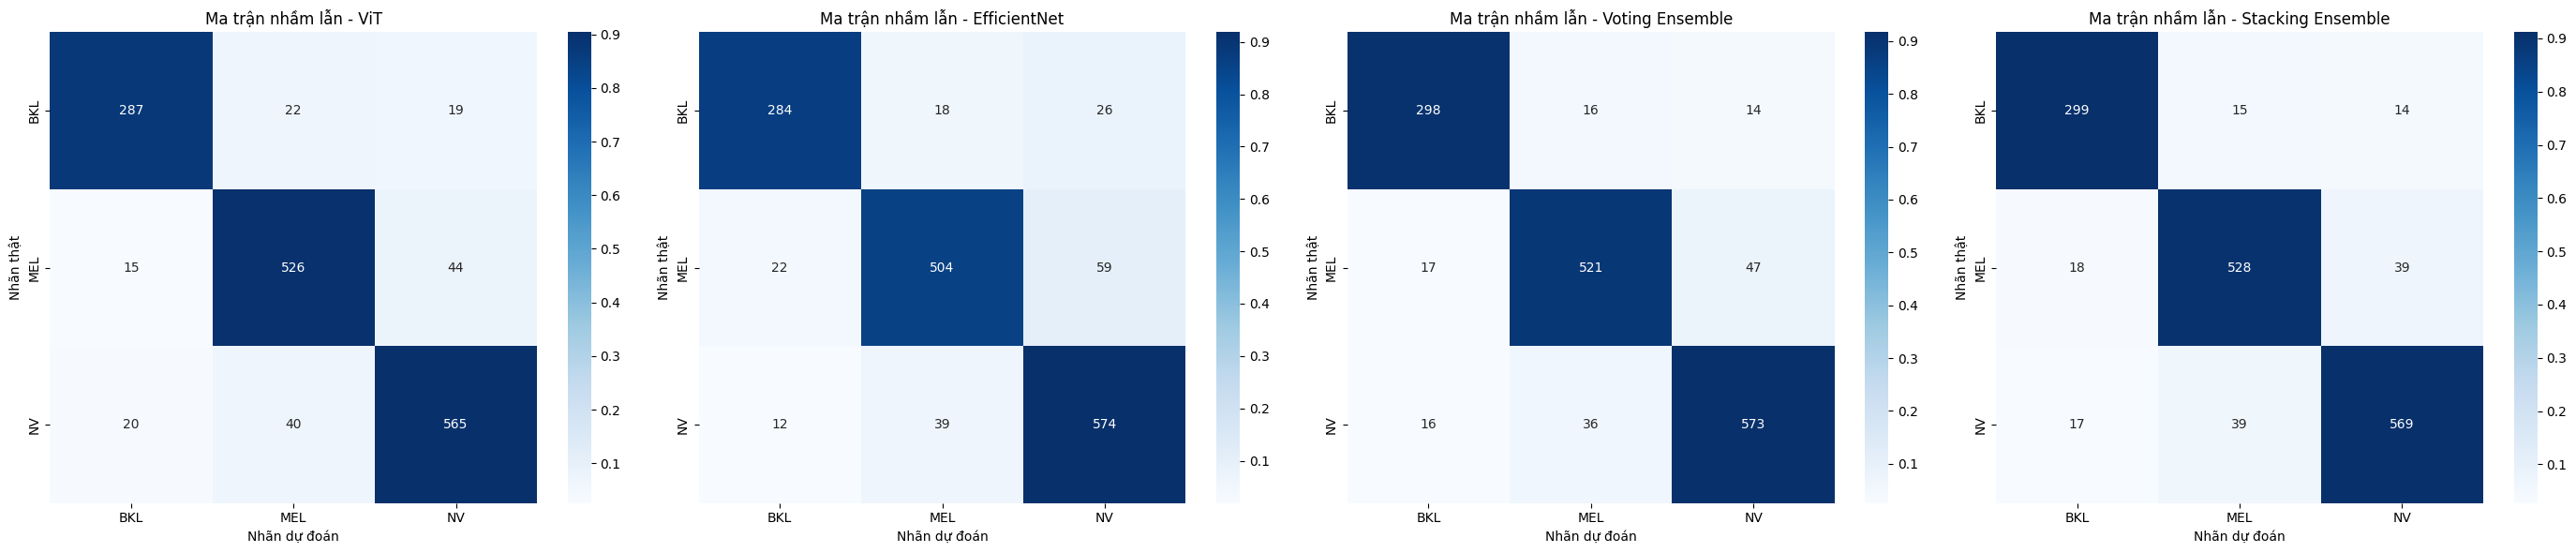

TypeError: cannot unpack non-iterable NoneType object

In [6]:
def main():
    # Tạo thư mục kết quả
    os.makedirs('results', exist_ok=True)
    
    # 1. Tải mô hình đã huấn luyện với hàm thông minh
    print("Đang tải mô hình đã huấn luyện...")
    
    # Đường dẫn đến các mô hình đã huấn luyện
    vit_model_path = '/kaggle/input/bklnvmel/pytorch/default/1/checkpoints/vit_base_patch16_224_best.pth'
    eff_model_path = '/kaggle/input/bklnvmel/pytorch/default/2/checkpoints/vit_meta_multiclass_focal_best.pth'
    
    # Khởi tạo mô hình với kiến trúc tương ứng
    vit_model = load_model_smart(
        vit_model_path, 
        device, 
        model_architecture='vit_base_patch16_224', 
        num_classes=3, 
        meta_dim=len(meta_feature_cols)
    )
    
    eff_model = load_model_smart(
        eff_model_path, 
        device, 
        model_architecture='efficientnet_b5', 
        num_classes=3, 
        meta_dim=len(meta_feature_cols)
    )
    
    # Chuyển các mô hình sang chế độ đánh giáoptimizer = torch.optim.SGD
    vit_model.eval()
    eff_model.eval()
    
    # 2. Tạo cả hai loại ensemble để so sánh
    print("Khởi tạo các mô hình ensemble...")
    
    stacking_ensemble = StackingEnsemble(
        base_models=[vit_model, eff_model], 
        num_classes=3,
        meta_dim=len(meta_feature_cols)
    )
    
    # Cũng tạo VotingEnsemble để so sánh
    voting_ensemble = VotingEnsemble(
        base_models=[vit_model, eff_model],
        weights=torch.tensor([0.5, 0.5])
    )
    
    # 3. Huấn luyện stacking ensemble trên tập validation
    print("Huấn luyện Stacking Ensemble...")
    stacking_ensemble = train_stacking_ensemble(
        stacking_ensemble, val_loader, device, num_epochs=10
    )
    
    # 4. Lưu các mô hình ensemble
    torch.save(stacking_ensemble, 'stacking_ensemble_model.pth')
    torch.save(voting_ensemble, 'voting_ensemble_model.pth')
    print("Đã lưu các mô hình ensemble")
    
    # 5. Đánh giá tất cả các mô hình trên tập test
    print("\nBắt đầu đánh giá các mô hình trên tập test...")
    models = [vit_model, eff_model, voting_ensemble, stacking_ensemble]
    model_names = ['ViT', 'EfficientNet', 'Voting Ensemble', 'Stacking Ensemble']
    
    metrics, confusion_matrices, predictions, true_labels = evaluate_models(
        models, model_names, test_loader, device, class_names
    )
    
    # 6. In bảng so sánh các chỉ số của 3 mô hình
    print("\n=== So sánh hiệu suất các mô hình ===")
    print(f"{'Model':<15} {'Accuracy':<10} {'Bal Acc':<10} {'AUC':<10} {'Macro F1':<10}")
    print("-" * 60)
    
    for name, model_metrics in metrics.items():
        acc = model_metrics['accuracy']
        bal_acc = model_metrics['balanced_accuracy']
        auc = model_metrics['auc']
        macro_f1 = model_metrics['report']['macro avg']['f1-score']
        
        print(f"{name:<15} {acc:<10.4f} {bal_acc:<10.4f} {auc:<10.4f} {macro_f1:<10.4f}")
    
    # 7. In báo cáo chi tiết cho từng mô hình
    for name, model_metrics in metrics.items():
        print(f"\n=== {name} Model ===")
        print(f"Classification Report:")
        report = model_metrics['report']
        
        print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Support':<10}")
        print("-" * 55)
        
        for cls in class_names:
            cls_metrics = report[cls]
            print(f"{cls:<10} {cls_metrics['precision']:<10.4f} {cls_metrics['recall']:<10.4f} {cls_metrics['f1-score']:<10.4f} {cls_metrics['support']:<10}")
        
        print(f"\n{'macro avg':<10} {report['macro avg']['precision']:<10.4f} {report['macro avg']['recall']:<10.4f} {report['macro avg']['f1-score']:<10.4f} {report['macro avg']['support']:<10}")
        print(f"{'w.avg':<10} {report['weighted avg']['precision']:<10.4f} {report['weighted avg']['recall']:<10.4f} {report['weighted avg']['f1-score']:<10.4f} {report['weighted avg']['support']:<10}")
    
    # 8. Vẽ ma trận nhầm lẫn
    plot_confusion_matrices(confusion_matrices, model_names, class_names)
    
# Chạy hàm main
if __name__ == "__main__":
    metrics, confusion_matrices, predictions, true_labels = main()